In [1]:
import numpy as np
from scipy import fft, optimize
import NAFFlib as naf
import statistics as st
import matplotlib.pyplot as plt
import time
from IPython.display import display, Math
import re
import csv

In [2]:
#Get data from all BPMs from sdds file
Name_xbpms = []
Name_ybpms = []
# sdds_file = 'data_Wed_Jun_28_20-13-14_2023'

# sdds_file = 'data_Wed_Jul_10_15_18_01_2024'
sdds_file = 'data_Wed_Jul_10_15_22_53_2024'
# sdds_file = 'data_Wed_Jul_10_15_25_35_2024'
# sdds_file = 'data_Wed_Jul_10_15_34_02_2024'

with open(sdds_file) as output:
    Lines = output.readlines()
    index_ix = index_jx = 0
    index_iy = index_jy = 0
    
    N_BPMx = int(Lines[63])
    N_BPMy = int(Lines[65])
    N_turns = int(Lines[64])
    Pos_xbpms = np.zeros([N_turns, N_BPMx])
    Pos_ybpms = np.zeros([N_turns, N_BPMy])
    S_xbpms = np.zeros([N_turns, N_BPMx])
    S_ybpms = np.zeros([N_turns, N_BPMy])
    
    
    init_i = 414
    end_y_index = N_BPMy*N_turns + init_i + 1
    for i, line in enumerate(Lines[1:]):
        Line = []
        #xBPM Names
        if i >= 67 and i < 95:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_xbpms.append(Line[:-1])
        
        #yBPM Names
        if i >= 241 and i < 269:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_ybpms.append(Line[:-1])
           
        #s and positions for xBPM
        if i > init_i:
            row = re.split("\s+", line)
            S_xbpms[index_ix][index_jx] = float(row[1])
            Pos_xbpms[index_ix][index_jx] = float(row[2])
            index_jx = (i - init_i)%N_BPMx
            
            if (i - init_i)%N_BPMx == 0 and (i - init_i) != 0:
                index_ix += 1
        
        #s and positions for yBPM
        if i > init_i and i < end_y_index:
            row = re.split("\s+", line)
            S_ybpms[index_iy][index_jy] = float(row[6])
            Pos_ybpms[index_iy][index_jy] = float(row[7])
            index_jy = (i - init_i)%N_BPMy
            
            if (i - init_i)%N_BPMy == 0 and (i - init_i) != 0:
                index_iy += 1
        
Name_xbpms = [item for row in Name_xbpms for item in row]
Name_ybpms = [item for row in Name_ybpms for item in row]

In [3]:
# Positions
init_turn = 0
N_turns = 1024
BPMx = Pos_xbpms[:N_turns].T
BPMy = Pos_ybpms[:N_turns].T

x = np.linspace(init_turn, N_turns, N_turns)
Omega = np.linspace(0, N_turns//2, N_turns//2)/N_turns


Mean of First Horizontal BPM = -1.3517021509179687
Standard deviation of First Horizontal BPM = 0.09794191699699697
Mean of First Vertical BPM = -0.5178896492657227
Standard deviation of First Vertical BPM = 0.1965038039946207


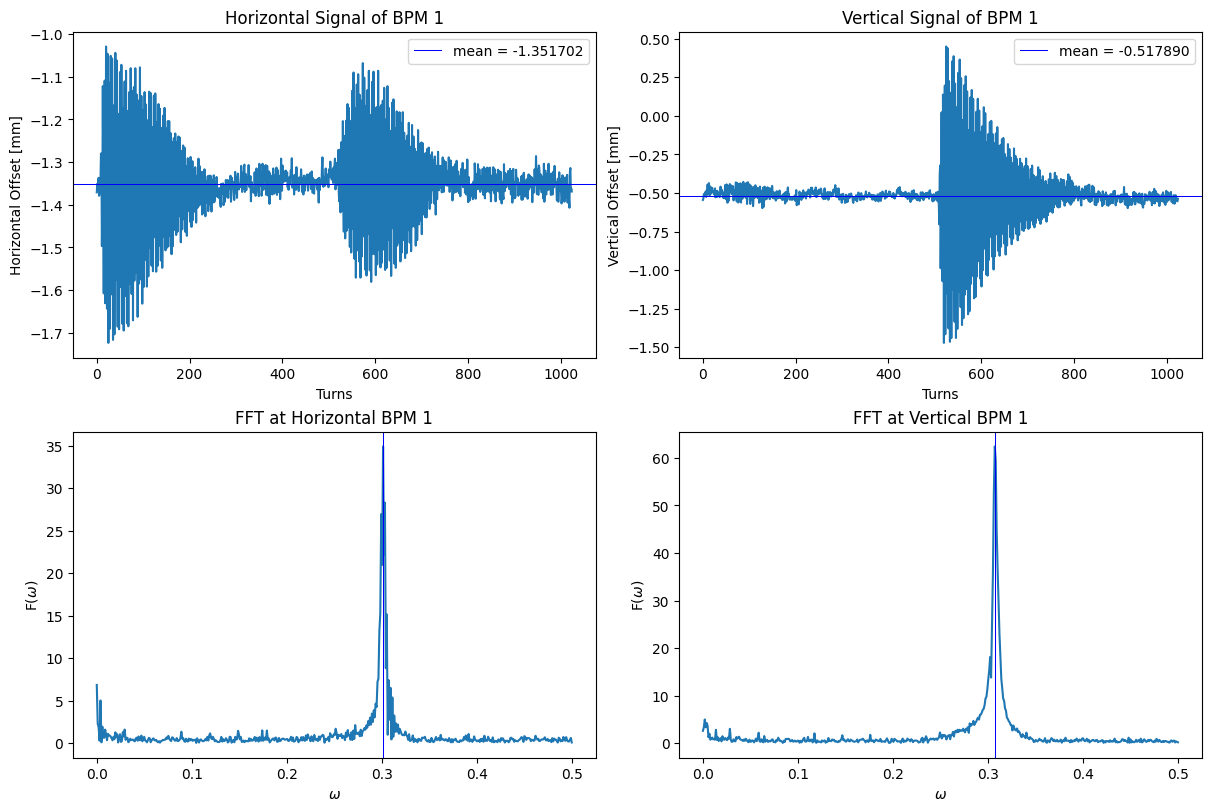

In [4]:
BPMx0 = BPMx[0]
N_turns = len(BPMx0)

BPMx0_mean = np.mean(BPMx0)
BPMx0_std = np.std(BPMx0)
print()
print("Mean of First Horizontal BPM =", BPMx0_mean)
print("Standard deviation of First Horizontal BPM =", BPMx0_std)

BPMy0 = BPMy[0]
BPMy0_mean = np.mean(BPMy0)
BPMy0_std = np.std(BPMy0)
print("Mean of First Vertical BPM =", BPMy0_mean)
print("Standard deviation of First Vertical BPM =", BPMy0_std)

fig, Ax = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')
x = np.linspace(0, N_turns, N_turns)
Ax[0][0].plot(x, BPMx0)
Ax[0][0].axhline(y = BPMx0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMx0_mean)
Ax[0][0].set_xlabel("Turns")
Ax[0][0].set_ylabel("Horizontal Offset [mm]")
Ax[0][0].set_title("Horizontal Signal of BPM 1")
Ax[0][0].legend()

Ax[0][1].plot(x, BPMy0)
Ax[0][1].axhline(y = BPMy0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMy0_mean)
Ax[0][1].set_xlabel("Turns")
Ax[0][1].set_ylabel("Vertical Offset [mm]")
Ax[0][1].set_title("Vertical Signal of BPM 1")
Ax[0][1].legend()

# Look at FFT graphs and tune of beam
Omega = np.linspace(0, N_turns//2, N_turns//2)/N_turns
BPMX0 = np.abs(fft.rfft(BPMx0)[1:])
BPMx0_Tune_scipy = Omega[np.argmax(BPMX0)]
Ax[1][0].plot(Omega, BPMX0)
Ax[1][0].axvline(x = BPMx0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%BPMx0_Tune_scipy)
Ax[1][0].set_title("FFT at Horizontal BPM 1")
Ax[1][0].set_xlabel(r"$\omega$")
Ax[1][0].set_ylabel(r"F($\omega$)")

BPMY0 = np.abs(fft.rfft(BPMy0)[1:])
BPMy0_Tune_scipy = Omega[np.argmax(BPMY0)]
Ax[1][1].plot(Omega, BPMY0)
Ax[1][1].axvline(x = BPMy0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%BPMy0_Tune_scipy)
Ax[1][1].set_title("FFT at Vertical BPM 1")
Ax[1][1].set_xlabel(r"$\omega$")
Ax[1][1].set_ylabel(r"F($\omega$)")
plt.show(block=False)
print()

Average Horizontal tune: 0.3013698630136986
Average Vertical tune: 0.3013698630136986


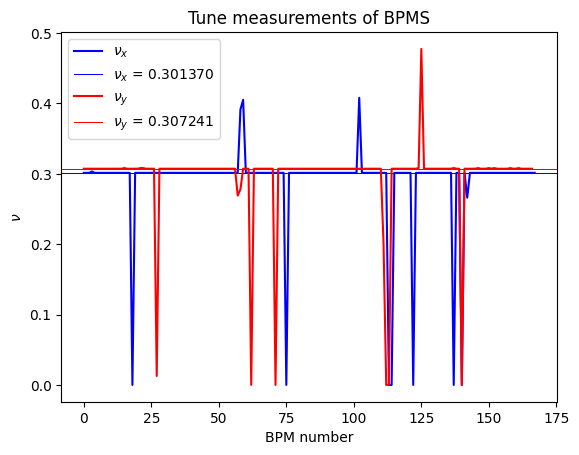

[18, 58, 59, 75, 102, 113, 114, 122, 137, 140, 142]
[27, 57, 58, 62, 71, 111, 112, 113, 125, 140]


In [18]:
# Look at all FFTs to figure out Tune of machine
BPMx_Tune_Map = np.zeros(N_BPMx)
for i in range(N_BPMx):
    BPMX = np.abs(fft.rfft(BPMx[i])[1:]) 
    BPMx_Tune_Map[i] = Omega[np.argmax(BPMX)]

BPMy_Tune_Map = np.zeros(N_BPMy)
for i in range(N_BPMy):
    BPMY = np.abs(fft.rfft(BPMy[i])[1:])
    BPMy_Tune_Map[i] = Omega[np.argmax(BPMY)]

nu_x, nu_y = st.mode(BPMx_Tune_Map), st.mode(BPMy_Tune_Map)
print("Average Horizontal tune:", nu_x)
print("Average Vertical tune:", nu_x)

plt.plot(BPMx_Tune_Map, color = 'b', label = r"$\nu_x$")
plt.axhline(y = nu_x, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%nu_x)
plt.plot(BPMy_Tune_Map, color = 'r', label = r"$\nu_y$")
plt.axhline(y = nu_y, color = 'r', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%nu_y)
plt.xlabel("BPM number")
plt.ylabel(r"$\nu$")
plt.title("Tune measurements of BPMS")
plt.legend()
plt.show()

def Bad_Bpms(Tune_Map, nu, N_BPM):
    Tune_Offset = np.abs(Tune_Map - np.ones(N_BPM)*nu)
    Bad_BPM = []
    for i, offset in enumerate(Tune_Offset):
        if offset > .005:
            Bad_BPM.append(i)
    return Bad_BPM
Bad_Bpmsx = Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx)
Bad_Bpmsy = Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy)
print(Bad_Bpmsx)
print(Bad_Bpmsy)

In [6]:
BetxModel = {}
AlfxModel = {}
BetyModel = {}
AlfyModel = {}
sModel = {}

# Get Linear optics from MADx
# twiss.out_Au16-s0store
# twiss.out_Au23-100GeV-e0-beta5
twiss_file = 'twiss.out_Au23-100GeV-e0store'

# Get Linear optics from MADx
with open(twiss_file) as output:
    Lines = output.readlines()
    for line in Lines:
        linelist = re.split("\s+", line)
        # print(linelist)
        if linelist[0] == '*':
            idx_s = linelist.index('S')
            idx_BETX = linelist.index('BETX')
            idx_ALFX = linelist.index('ALFX')
            idx_BETY = linelist.index('BETY')
            idx_ALFY = linelist.index('ALFY')
        
        if linelist[0] == '':
            sModel[linelist[1][1:-1]] = float(linelist[idx_s])
            BetxModel[linelist[1][1:-1]] = float(linelist[idx_BETX])
            AlfxModel[linelist[1][1:-1]] = float(linelist[idx_ALFX])
            BetyModel[linelist[1][1:-1]] = float(linelist[idx_BETY])
            AlfyModel[linelist[1][1:-1]] = float(linelist[idx_ALFY])
BetxBPMModel = []
BetyBPMModel = []
AlfxBPMModel = []
AlfyBPMModel = []
# Get MADx values of Beta and Alpha from BPMs
for elem in sModel:
    if ("_B" in elem and 
        elem != "G10_BX.1" and 
        elem != "G10_BX.2" and 
        "Q" not in elem and 
        "T" not in elem and 
        "BB" not in elem):
        if "V" not in elem: 
            BetxBPMModel.append(BetxModel[elem])
            AlfxBPMModel.append(AlfxModel[elem])
        if "H" not in elem and elem != "BI9_B3.1": 
            BetyBPMModel.append(BetyModel[elem])
            AlfyBPMModel.append(AlfyModel[elem])

# Curve Fitting

In [7]:
def fit_function(x, a, b, c, d):
    return a*np.exp(-2*(np.pi*x)**2/b**2)*np.cos(2*np.pi*c*x + d)

In [8]:
# Calculate Parameters
# This step changes depending on what the TBT data looks like
Paramsx = np.zeros([len(BPMx), 4])
for i in range(len(BPMx)):
    # print(i)
    BPMx_mean = np.mean(BPMx[i])
    BPMx_std = np.std(BPMx[i])
    
    ttrain = np.linspace(0, N_turns - 1, N_turns)[15:250]
    xtrain = (BPMx[i] - BPMx_mean)[15:250]
    B = 300
    p0 = 1, B, BPMx0_Tune_scipy, 0
    params, params_cov = optimize.curve_fit(fit_function, ttrain, xtrain, p0=p0)
    # print(params)
    Paramsx[i] = params
    

/Users/GrandmasterFung/env/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


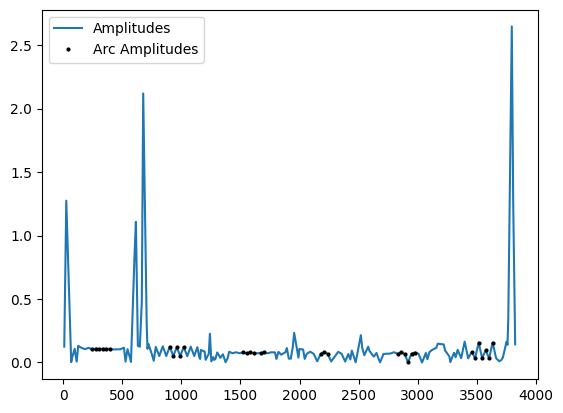

In [9]:
# Calculate amplitude function
sArc = [[231, 410.5], [882, 1032.3], [1509, 1717.5], [2160, 2250.5], [2817, 2995.5], [3438, 3646.5]] 
Ampx2 = np.zeros(len(BPMx))
arcAmpx2 = []
sarcAmpx2 = []
for i in range(len(Paramsx)):
    if i not in Bad_Bpmsx:
        Ampx2[i] = Paramsx[i, 0]**2
        for interval in sArc:
            if S_xbpms[0, i] > interval[0] and S_xbpms[0, i] < interval[1]:
                arcAmpx2.append(Paramsx[i, 0]**2)
                sarcAmpx2.append(S_xbpms[0, i])

for i in Bad_Bpmsx:
    Ampx2[i] = (Ampx2[i - 1] + Ampx2[i + 1])/2

plt.plot(S_xbpms[0], Ampx2, label = "Amplitudes")
plt.plot(sarcAmpx2, arcAmpx2, 'ko', ms = 2, label = "Arc Amplitudes")
plt.legend()
plt.show()
    

In [10]:
#model beta in arc sections
arcBetxModel = []
for elem in sModel:
    if "_B" in elem and "V" not in elem:
        # print(elem)
        for interval in sArc:
            if sModel[elem] > interval[0] and sModel[elem] < interval[1]:
                arcBetxModel.append(BetxModel[elem])

# # get rid of repeats
# arcBetxModel = set(arcBetxModel)
# arcBetxModel = list(arcBetxModel)


In [11]:
len(arcBetxModel)

34

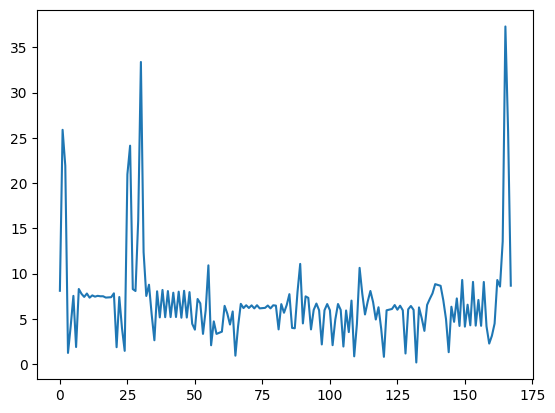

In [12]:
# calculate experimental beta function
K = np.mean(arcBetxModel)/np.mean(arcAmpx2)
Betx = Ampx2*K
plt.plot(np.sqrt(Betx))
plt.show()

In [13]:
print("name", "\t", "model","\t \t", "machine")
for i in range(N_BPMx):
    print(Name_xbpms[i], BetxBPMModel[i], Betx[i])

name 	 model 	 	 machine
g6-bx 92.63137608 65.70985493209751
bo6-b1 901.2568975 670.2381283138253
bo6-b3 668.8736868 480.7849135197186
bo6-b3.1 2.448355049 1.5342136608223322
bo6-b4 21.36679023 17.582192645893585
bo6-bh6 38.18770509 56.88564881391688
bo6-b7 7.481739673 3.568157108214808
bo6-b8 49.81374691 68.9232853597957
bo6-bh10 43.76119823 60.37815314143045
bo6-bh12 43.65300524 55.15934213405964
bo6-bh14 44.44419006 60.84417515898029
bo6-bh16 43.04162695 53.91544912884159
bo6-bh18 44.91092109 57.68165837329105
bo6-bh20 42.82060006 55.60529015085881
bo7-bh20 44.88058784 56.93438824128444
bo7-bh18 43.00058186 56.212903733974336
bo7-bh16 44.58505761 56.239156429276726
bo7-bh14 43.2836317 54.070360958836794
bo7-bh12 44.26172068 54.37419704612849
bo7-bh10 43.73456583 54.67803313342018
bo7-b8 48.99306529 61.208891011097705
bo7-b7 7.630544013 3.4983790941399144
bo7-bh6 38.37990234 54.991267433141786
bo7-b4 19.81053806 15.692252084638831
bo7-b3.1 2.727872244 2.1511773507256726
bo7-b3 658.98

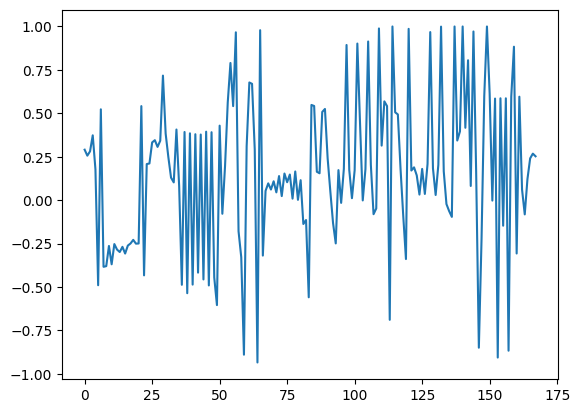

In [14]:
# Calculate beta beat
Beatx = (BetxBPMModel - Betx)/BetxBPMModel
for i, beat in enumerate(Beatx):
    if abs(beat) > 1: Beatx[i] = 1
        
plt.plot(Beatx)
plt.show()

In [17]:
for i in range(N_BPMx - 1):
    print(Name_xbpms[i], Beatx[i])

g6-bx 0.2906306943411056
bo6-b1 0.25632954358185617
bo6-b3 0.2812022314409295
bo6-b3.1 0.3733696175115767
bo6-b4 0.177125227671897
bo6-bh6 -0.4896325579096714
bo6-b7 0.5230845680060849
bo6-b8 -0.38361977637059663
bo6-bh10 -0.3797189195801976
bo6-bh12 -0.26358636320223355
bo6-bh14 -0.36900177676407625
bo6-bh16 -0.2526350175255535
bo6-bh18 -0.28435705555223223
bo6-bh20 -0.29856401061510063
bo7-bh20 -0.2685749225089571
bo7-bh18 -0.30725914167837587
bo7-bh16 -0.26139023798553584
bo7-bh14 -0.2492103558592287
bo7-bh12 -0.2284700235501211
bo7-bh10 -0.25022467002321164
bo7-b8 -0.24933785320003415
bo7-b7 0.5415295307674265
bo7-bh6 -0.4328141574198124
bo7-b4 0.20788360027820305
bo7-b3.1 0.2114083218313384
bo7-b3 0.3325264639884777
bo7-b1 0.3453452391951949
g7-bx 0.3067505154831573
g8-bx 0.34224298973474954
bi8-b1 0.7172047639864225
bi8-b3 0.38348941868745484
bi8-b3.1 0.24829652718193612
bi8-b4 0.1297461652612589
bi8-bh5 0.1023881749329695
bi8-b7 0.40677144064237375
bi8-b8 0.08195436385975173
bi8

In [16]:
sIP = [0, 639.445027949618, 1277.94839381844, 1917.39342276804]
IPBPMx = [(167, 0), (27, 28), (57, 60), (86, 87)]
P0 = [.7, .7, 10, 10]
Cir = 3833.845181
def fit_beta(x, b1, s1):
    return b1 + ((x-s1)**2)/b1

# Calculate Parameters
# This step changes depending on what the TBT data looks like
IPParamsx = np.zeros([len(sIP), 2])
for i in range(len(sIP)):
    print(Name_xbpms[IPBPMx[i][0]], Name_xbpms[IPBPMx[i][1]])
    BPMx_mean = np.mean(BPMx[i])
    BPMx_std = np.std(BPMx[i])

    if i == 0: ttrain = np.array([S_xbpms[0][IPBPMx[i][0]] - Cir, S_xbpms[0][IPBPMx[i][1]]])
    else: ttrain = np.array([S_xbpms[0][IPBPMx[i][0]], S_xbpms[0][IPBPMx[i][1]]]) - sIP[i]
    xtrain = np.array([Betx[IPBPMx[i][0]], Betx[IPBPMx[i][1]]])
    p0 = np.array([P0[i], 0])
    params, params_cov = optimize.curve_fit(fit_beta, ttrain, xtrain, p0=p0)
    IPParamsx[i] = params

g5-bx g6-bx
g7-bx g8-bx
g9-bx g10-bx
g11-bx g12-bx


In [19]:
print(IPParamsx)

[[0.95951131 0.11091487]
 [1.051151   0.10910258]
 [9.56568431 2.70881117]
 [8.32613104 0.0684922 ]]


In [149]:
filename1 = 'g_IP_results/Wed_Jul_10_15_18_01_2024'
filename2 = "g_IP_results/Wed_Jul_10_15_22_53_2024"
filename3 = "g_IP_results/Wed_Jul_10_15_25_35_2024"
Filenames = [filename1, filename2, filename3]
Gx_Data = []
Gy_Data = []
for i, filename in enumerate(Filenames):
    IP_vals = []
    print(filename)
    with open(filename) as output:
        Lines = csv.reader(output, delimiter = ',', quotechar = '|')
        Lines_list = list(Lines)
        Namex_Jul_10_15_22_53_2024_g = Lines_list[0]
        sx_loc_Jul_10_15_22_53_2024_g = np.array(list(map(float, Lines_list[1])))
        Betx_Jul_10_15_22_53_2024_g = np.array(list(map(float, Lines_list[2])))**2
        Namey_Jul_10_15_22_53_2024_g = Lines_list[3]
        sy_loc_Jul_10_15_22_53_2024_g = np.array(list(map(float, Lines_list[4])))
        Bety_Jul_10_15_22_53_2024_g = np.array(list(map(float, Lines_list[5])))**2
        for line_index, line in enumerate(Lines_list[6:-4]):
            IP_vals.append(np.array(list(map(float, line))))

    IP_vals = np.array(IP_vals)
    
    IP_search = ['g5-bx', 'g6-bx', 'g7-bx', 'g8-bx', 'g9-bx', 'g10-bx', 'g11-bx', 'g12-bx']
    IP_indices = np.zeros(len(IP_search), dtype = int)
    for i, ip in enumerate(IP_search):
        IP_indices[i] = Namex_Jul_10_15_22_53_2024_g.index(ip)
        
    Betx_IP_Jul_10_15_22_53_2024_g = Betx_Jul_10_15_22_53_2024_g[IP_indices]
    sx_loc_IP_Jul_10_15_22_53_2024_g = sx_loc_Jul_10_15_22_53_2024_g[IP_indices]
    C = 3833.845181
    sx_loc_IP_Jul_10_15_22_53_2024_g[0] -= C
    
    Bety_IP_Jul_10_15_22_53_2024_g = Bety_Jul_10_15_22_53_2024_g[IP_indices]
    sy_loc_IP_Jul_10_15_22_53_2024_g = sy_loc_Jul_10_15_22_53_2024_g[IP_indices]
    sy_loc_IP_Jul_10_15_22_53_2024_g[0] -= C

    gx_data = np.array([Betx_IP_Jul_10_15_22_53_2024_g[::2],
                   IP_vals[::2, 0],
                   IP_vals[::2, 1],
                   Betx_IP_Jul_10_15_22_53_2024_g[1::2]])
    gy_data = np.array([Bety_IP_Jul_10_15_22_53_2024_g[::2],
                   IP_vals[1::2, 0],
                   IP_vals[1::2, 1],
                   Bety_IP_Jul_10_15_22_53_2024_g[1::2]])
    
    Gx_Data.append(gx_data)
    Gy_Data.append(gy_data)
Gx_Data = np.array(Gx_Data)
Gy_Data = np.array(Gy_Data)
    

g_IP_results/Wed_Jul_10_15_18_01_2024
g_IP_results/Wed_Jul_10_15_22_53_2024
g_IP_results/Wed_Jul_10_15_25_35_2024


In [164]:
# intersection = list(set(Names_Jul_10_15_22_53_2024_g) & set(Name_xbpms))
print()
mod_betx_ring = np.zeros(len(Name_xbpms))
i = 0
for bpm in Name_xbpms:
    if bpm in Names_Jul_10_15_22_53_2024_g:
        mod_betx_ring[i] = Betx_Jul_10_15_22_53_2024_g[Names_Jul_10_15_22_53_2024_g.index(bpm)]
    i += 1
print(mod_betx_ring)


[7.79915673e+01 7.94610763e+02 5.67415888e+02 7.23486514e-01
 2.36198890e+01 6.15450567e+01 2.66354936e+00 8.48705060e+01
 6.06347456e+01 6.16361784e+01 6.39297255e+01 5.84011125e+01
 5.94496101e+01 0.00000000e+00 5.72964684e+01 6.45841173e+01
 5.13174412e+01 5.31819388e+01 0.00000000e+00 6.32559959e+01
 5.67798896e+01 3.23269881e+00 5.88754960e+01 1.53572289e+01
 2.97132944e+00 4.81461992e+02 5.92635635e+02 7.08254099e+01
 6.93546642e+01 5.58091677e+02 1.22346705e+03 9.51520364e+01
 4.80945638e+01 8.42602941e+01 3.20562505e+01 7.23012249e+00
 6.92835888e+01 2.92754206e+01 6.60442557e+01 2.96803910e+01
 6.83515798e+01 2.48704695e+01 6.79683480e+01 2.85273137e+01
 6.92704104e+01 2.95607868e+01 6.55566564e+01 2.62846498e+01
 6.16655846e+01 2.20235258e+01 1.76332039e+01 5.43648094e+01
 4.24828917e+01 1.16722883e+01 0.00000000e+00 1.13051861e+02
 8.23252621e+01 2.03490361e+01 0.00000000e+00 0.00000000e+00
 1.28010415e+01 4.84315345e+01 3.18319002e+01 2.27752445e+01
 3.57252187e+01 5.19434

In [41]:
def fit_beta(x, b1, s1):
        if b1 == 0: return b1
        return b1 + ((x-s1)**2)/b1
sIPs = [0, 639.445027949618, 1277.94839381844, 1917.39342276804]
Beta_star = [.9, .9, 10, 10]
for i in range(4):
    s1, s2 = s_loc_IP_Jul_10_15_22_53_2024_g[2*i: 2*i+2]
    sIP = sIPs[i]
    
    tB = [s1 - sIP, s2 - sIP]
    print(tB)
    xB = Betx_IP_Jul_10_15_22_53_2024_g[2*i: 2*i+2]
    pB = [Beta_star[i], 0]
    parB, covB = optimize.curve_fit(fit_beta, tB, xB, p0=pB)
    print(parB)

[-8.32618100000036, 7.993]
[0.86743057 0.07821658]
[-8.326027949617924, 8.325972050382006]
[1.056391   0.28890284]
[-8.32639381844001, 8.32660618156001]
[12.31573415  3.63377059]
[-8.326422768039947, 8.326577231960073]
[8.3251085  0.15162889]


/Users/GrandmasterFung/env/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [217]:
Betx_Jul_10_15_22_53_2024_g = np.array([8.548981226859134, 27.293920285504775, 23.218482154932474, 1.3089312344199546, 3.778869224167077, 7.656364177047431, 1.9094778720335006, 8.047481962725989, 8.293156308131378, 7.452724942276176, 8.059253591865149, 7.715097655810413, 7.360232099806441, 8.023160082280132, 7.787649886587286, 7.73648695088758, 7.711695047523513, 7.7384818072392, 8.312110764700456, 1.7672405498754384, 7.062962840887156, 4.092291640512875, 2.970777356575857, 22.210290832562592, 25.467198385846306, 8.44462306841522, 7.886873104609946, 25.194899149495935, 33.993693036627334, 13.268713563872808, 6.994863162938657, 9.337905028750981, 5.888390356197283, 2.7480116128554686, 7.823734594804831, 5.530129393514453, 8.639838910372845, 5.528151201704677, 8.196148224188388, 5.459315264799183, 8.074252416050744, 5.5891398222556905, 7.769162493336476, 5.460674743640517, 8.535020278039372, 5.105784523462788, 8.360281179666726, 4.67958437280259, 3.7569896990213114, 7.692229400043392, 6.719631568854193, 3.555828406363839, 8.937325683688595, 11.33190893798585, 8.593555845481093, 4.891890691996094, 3.7555173549665133, 6.81695267502588, 5.576073687186249, 4.659415551787559, 6.252334689524368, 7.155848161073514, 4.210076895359153, 7.187423415800685, 6.407790843411583, 6.7844970864515854, 6.3972919182683805, 6.5010446190609565, 6.394284097607972, 6.633133466099639, 6.494892195092222, 6.349416959435493, 6.968345590637665, 6.682609726021479, 3.916350248648939, 7.020551403401134, 4.994424777536149, 6.900677165458116, 8.075967437694258, 4.016632136820565, 3.9365435034413077, 8.354811674843727, 4.722221275159579, 7.860309955090343, 7.377410893439958, 3.9414198722157483, 6.253567632997578, 7.1428641077950195, 6.226823379272424, 7.196327557748627, 5.980126857867992, 7.12341475778511, 6.388553961306596, 7.0719134300944955, 7.087131196533352, 6.000883754812425, 7.121336878300697, 6.184015772341476, 3.4637770520508697, 7.1459551746698295, 7.778981727570161, 4.457572456154984, 11.047840976977083, 7.75741484954097, 8.730092479955797, 7.456962846610803, 4.933706488899861, 6.622078951876602, 4.17501441391527, 6.94683856713769, 6.445725122390963, 5.871020712468433, 6.8166981551584565, 6.460784531131629, 6.752915625870839, 6.3707822474105065, 6.528852371952916, 5.812489394715998, 6.72358315369577, 6.407408672369248, 6.7238521431750895, 6.535998279033131, 5.038980591481075, 3.6657572195046697, 6.770423957036467, 8.191034686744368, 9.25904296745033, 7.91533077903671, 5.2875994055964215, 8.266982886946586, 6.721499616248397, 4.638837832926778, 9.489525055394719, 4.4815314965627735, 9.769586962127295, 4.4243688236350645, 9.362628734103044, 4.466097603525002, 9.281674219201822, 4.329381769075953, 9.592055170622482, 4.496668934153144, 8.866546638506357, 4.3236917152782395, 9.32918760685043, 3.1468665828913998, 4.734459644079321, 8.949929364559386, 14.408939725871459, 39.13059481832174, 25.991867614662446, 9.071731345434149])**2
Betx_Jul_10_15_25_35_2024_g = np.array([8.831283443078366, 28.18884111142285, 23.82049302819785, 0.8505801046211322, 4.860029727949774, 7.84506575685869, 1.6320384062166897, 9.212518981886472, 7.78683154922378, 7.85087118821187, 7.995606638554506, 7.642062059063362, 7.7103573272611055, 7.5694430675929825, 8.036424409557565, 7.1636192839234525, 7.292594793410044, 7.953363811594159, 7.535243168583939, 1.7979707472964814, 7.673036948244313, 3.9188300391374074, 1.7237544614035127, 21.94224217485348, 24.344108842274323, 8.41578338204461, 8.327944775525644, 23.623964031198533, 34.97809388362107, 9.754590527061946, 6.935024423355338, 9.179340611218308, 5.66182395323631, 2.6888887096487597, 8.323676398784661, 5.410676534469989, 8.12676170040226, 5.447971269342347, 8.267501424281377, 4.987030129339746, 8.244291844360092, 5.341096671833991, 8.322884741546293, 5.436983247094511, 8.09670651470414, 5.126855746637134, 7.85274376415069, 4.692922950354333, 4.199190857641632, 7.373249583958724, 6.5178901265794025, 3.4164730720187673, 8.759912255193877, 10.632584888987433, 9.073326959115036, 4.510990591116692, 3.577854309358783, 6.959276868059092, 5.641976625246959, 4.77234161881229, 5.977057694328572, 7.207182356376887, 4.335045875189001, 5.907245827753566, 6.278361027351911, 6.072714756586623, 6.528003501992492, 6.251021533076374, 6.132780025746897, 6.667980525669828, 6.2109214546490765, 6.196741818383265, 6.398397603665777, 6.506328459258783, 3.598670832484804, 6.552674338528653, 6.084080508132662, 6.573752071675233, 7.755347810389606, 4.1537725059418245, 3.7043015475480954, 7.932423970677106, 3.6297669946162325, 8.031516395182722, 6.781923357719344, 3.615791082279125, 5.689078605990613, 6.951407495258463, 5.9177067551027225, 6.767988622563292, 5.301632640592803, 7.0714357905471195, 5.673787912042518, 7.075386743754162, 6.836779526464884, 5.478185212074692, 6.278265404358082, 5.353112536627927, 3.371970009263274, 7.70984283396335, 7.3621129058024035, 4.219601630502687, 10.667452554256219, 7.809179396828965, 7.829211322324983, 6.575611121532897, 4.970698094461357, 6.668023235173926, 4.188615664985182, 7.121446244181574, 5.81500621891748, 5.742449132068246, 6.862322696438888, 5.476106735283535, 6.696934893747518, 5.904928013380301, 6.176680991349005, 6.061947968828967, 6.86400786313728, 6.237199847487804, 6.844424920620539, 6.134253948308221, 5.1430916754239755, 3.9806066686823036, 7.32912438030635, 8.200904612133678, 9.510854566425198, 9.124211947448199, 5.18814878020199, 8.059228228269731, 6.522571150370121, 4.9748736832536595, 9.913130125226825, 3.160841028158825, 9.342999317126667, 4.358951782038649, 9.811641067180348, 4.466142897046008, 9.659301749206682, 4.495890694794332, 10.160217532246959, 4.390159534663504, 9.892630906042728, 4.579944841730781, 9.722761429518416, 3.0865383748354263, 4.321440914819648, 7.221149446014919, 8.511177010957663, 14.877427037357815, 39.56735340200948, 26.917543028958338, 9.346029354887905])**2

ggg = np.array(['g6-bx', 'bo6-b1', 'bo6-b3', 'bo6-b3.1', 'bo6-b4', 'bo6-bh6', 'bo6-b7', 'bo6-b8', 'bo6-bh10', 'bo6-bh12', 'bo6-bh14', 'bo6-bh16', 'bo6-bh18', 'bo7-bh20', 'bo7-bh18', 'bo7-bh16', 'bo7-bh14', 'bo7-bh10', 'bo7-b8', 'bo7-b7', 'bo7-bh6', 'bo7-b4', 'bo7-b3.1', 'bo7-b3', 'bo7-b1', 'g7-bx', 'g8-bx', 'bi8-b1', 'bi8-b3', 'bi8-b3.1', 'bi8-b4', 'bi8-bh5', 'bi8-b7', 'bi8-b8', 'bi8-bh9', 'bi8-bh11', 'bi8-bh13', 'bi8-bh15', 'bi8-bh17', 'bi8-bh19', 'bi9-bh21', 'bi9-bh19', 'bi9-bh17', 'bi9-bh15', 'bi9-bh13', 'bi9-bh11', 'bi9-bh9', 'bi9-b8', 'bi9-b7.1', 'bi9-b7', 'bi9-bh5', 'bi9-b4', 'bi9-b3.1', 'bi9-b3', 'bi9-b1', 'g9-bx', 'g10-bx', 'bo10-b1', 'bo10-b3', 'bo10-b3.1', 'bo10-b4', 'bo10-bh6', 'bo10-b7', 'bo10-b8', 'bo10-bh10', 'bo10-bh12', 'bo10-bh14', 'bo10-bh20', 'bo11-bh20', 'bo11-bh16', 'bo11-bh14', 'bo11-bh12', 'bo11-bh10', 'bo11-b8', 'bo11-b7', 'bo11-bh6', 'bo11-b4', 'bo11-b3', 'bo11-b1', 'g11-bx', 'g12-bx', 'bi12-b1', 'bi12-b4', 'bi12-bh5', 'bi12-b7', 'bi12-b8', 'bi12-bh9', 'bi12-bh11', 'bi12-bh13', 'bi12-bh15', 'bi12-bh17', 'bi12-bh19', 'bi1-bh21', 'bi1-bh19', 'bi1-bh15', 'bi1-bh13', 'bi1-bh11', 'bi1-bh9', 'bi1-b8', 'bi1-b7', 'bi1-bh5', 'bi1-b4', 'bi1-b3', 'bi1-b1', 'bo2-b1', 'bo2-b3', 'bo2-b4', 'bo2-bh6', 'bo2-b7', 'bo2-b8', 'bo2-bh10', 'bo2-bh14', 'bo2-bh16', 'bo2-bh18', 'bo2-bh20', 'bo3-bh20', 'bo3-bh18', 'bo3-bh16', 'bo3-bh14', 'bo3-bh12', 'bo3-bh10', 'bo3-b8', 'bo3-b7.1', 'bo3-b7', 'bo3-bh6', 'bo3-b3', 'bo3-b1', 'bi4-b1', 'bi4-b4', 'bi4-bh5', 'bi4-b7', 'bi4-b8', 'bi4-bh9', 'bi4-bh11', 'bi4-bh13', 'bi4-bh15', 'bi4-bh17', 'bi4-bh19', 'bi5-bh21', 'bi5-bh19', 'bi5-bh17', 'bi5-bh15', 'bi5-bh13', 'bi5-bh11', 'bi5-bh9', 'bi5-b8', 'bi5-b7', 'bi5-bh5', 'bi5-b4', 'bi5-b3.1', 'bi5-b3', 'bi5-b1', 'g5-bx'])
index_bi9_b3_1 = list(ggg).index('bi9-b3.1')
ggg = np.delete(ggg, index_bi9_b3_1)
Betx_Jul_10_15_25_35_2024_g = np.delete(Betx_Jul_10_15_25_35_2024_g, index_bi9_b3_1)
overlap = np.intersect1d(Name_xbpms, ggg)

Betx_rev = []
# index = 0
for i, bpm in enumerate(Name_xbpms):
    if bpm in ggg: 
        # print(bpm, ggg[index])
        Betx_rev.append(Betx[i])
        # index += 1
    
Betx_rev = np.array(Betx_rev)


In [218]:
Betx_rev.shape

(152,)

In [219]:
for i in range(len(Betx_Jul_10_15_25_35_2024_g)):
    print(Betx_Jul_10_15_25_35_2024_g[i], Betx_rev[i])

77.99156725199008 65.70985493209751
794.610763205043 670.2381283138253
567.4158881064224 480.7849135197186
0.7234865143772962 1.5342136608223322
23.619888956555556 17.582192645893585
61.545056729436816 56.88564881391688
2.663549359366313 3.568157108214808
84.87050599161856 68.9232853597957
60.634745575986805 60.37815314143045
61.63617841389526 55.15934213405964
63.92972551849688 60.84417515898029
58.40111251457576 53.91544912884159
59.449610114049015 57.68165837329105
57.29646835353146 56.93438824128444
64.58411729053266 56.212903733974336
51.317441244999955 56.239156429276726
53.18193882087128 54.070360958836794
63.255995919575575 54.67803313342018
56.779889609690926 61.208891011097705
3.232698808133868 3.4983790941399144
58.8754960091224 54.991267433141786
15.357228875645694 15.692252084638831
2.971329443208514 2.1511773507256726
481.46199165991874 439.85718364338413
592.6356353244989 582.6089682561463
70.82540993349822 68.74482108873262
69.35466418420488 65.28825227676703
558.091676

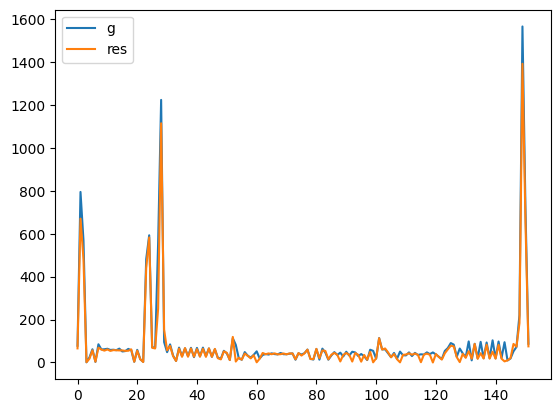

In [220]:
# plt.plot(Betx, label = "curve fit result")
plt.plot(Betx_Jul_10_15_25_35_2024_g, label = "g")
plt.plot(Betx_rev, label = "res")
plt.legend()
plt.show()

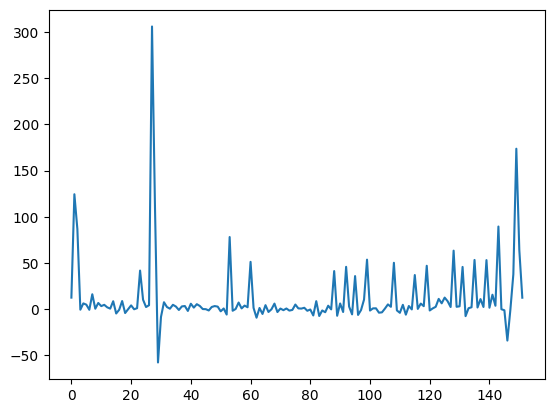

In [221]:
plt.plot(Betx_Jul_10_15_25_35_2024_g - Betx_rev)
plt.show()

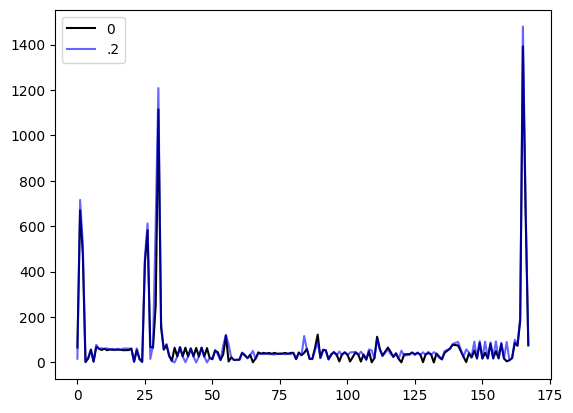

In [266]:
plt.plot(Betx_Jul_10_15_22_53_2024, "k", label = "0")
# plt.plot(Betx_Jul_10_15_25_35_2024, "r", label = ".1", alpha = .5)
plt.plot(Betx_Jul_10_15_34_02_2024, "b", label = ".2", alpha = .6)
plt.legend()
# plt.ylim([-10, 500])
plt.show()